[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/polislizarralde/PythonPlayground/blob/main/docs/PlagueProject/FittingMetapopModelPlague.ipynb)

In [1]:
#Python 3.11.2
#Import packages
import scipy.integrate as scipy
import scipy.optimize as optimize
import scipy.stats as stats
import pandas as pd
import numpy as np
import pylab as pl
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import json # for pretty printing

import shutil
import sys
import os.path

Initializing the population size and initial conditions:

In [2]:
 # vector of population sizes with lenght n
n = 19
N = np.array([204  # Bromma
              , 217  # Oja
              , 1895  # S Maria Ystad 1749
              , 554  # Valleberga
              , 693  # S Kopinge
              , 403  # Horups
              , 582  # Bjäresjö 1780
              , 716  # Villie 1749
              , 418  # Snårestad 1775
              , 519  # Skårby 1749
              , 262  # Hammenhögs 1749
              , 560  # Glemminge 1775
              , 236  # Balkåkra 1775
              , 334  # Baldringe 1749
              , 299  # Ovraby
              , 761  # Sövestads 1749
              , 776  # Löderups 1749
              , 951  # Borrby 1775
              , 358  # Tosterups 1775
              ]) 
# Initial conditions for each patch
E0 = np.zeros(n)  # vector of initial exposed with length n

I0 = np.zeros(n)  # vector of initial infecteds with length n
I0[0] = 1.0  # the first element of the I0 vector is set to 1

S0 = np.zeros(n)  # vector of initial susceptibles with length n
for i in range(n):
    S0[i] = N[i] - I0[i]

R0 = np.zeros(n)  # vector of initial removeds with length n
D0 = np.zeros(n)  # vector of initial deaths with length n

#print(S0,I0,R0,D0)

In [3]:
# Defining the transmission rate matrix as a function of two parameters

def TransmissionRateMatrix(beta: float, p: float)-> np.ndarray:
    return(
        np.array([
            [beta, p, 0, 0, 0, 0, p, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 0, 0],
            [p, beta, p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, p, beta, 0, p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, beta, 0, p, 0, 0, 0, 0, 0, p, 0, 0, 0, 0, p, 0, 0],
            [0, 0, p, 0, beta, 0, 0, 0, 0, 0, 0, p, 0, 0, p, 0, 0, 0, p],
            [0, 0, 0, p, 0, beta, 0, 0, 0, 0, p, p, 0, 0, 0, 0, p, p, 0],
            [p, 0, 0, 0, 0, 0, beta, 0, 0, p, 0, 0, p, 0, 0, p, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, beta, 0, p, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, beta, 0, 0, 0, p, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, p, p, 0, beta, 0, 0, p, 0, 0, p, 0, 0, 0],
            [0, 0, 0, 0, 0, p, 0, 0, 0, 0, beta, 0, 0, 0, 0, 0, 0, p, 0],
            [0, 0, 0, p, p, p, 0, 0, 0, 0, 0, beta, 0, 0, 0, 0, 0, 0, p],
            [0, 0, 0, 0, 0, 0, p, 0, p, p, 0, 0, beta, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, beta, 0, p, 0, 0, 0],
            [0, 0, 0, 0, p, 0, 0, 0, 0, 0, 0, 0, 0, 0, beta, 0, 0, 0, p],
            [p, 0, 0, 0, 0, 0, p, 0, 0, p, 0, 0, 0, p, 0, beta, 0, 0, 0],
            [0, 0, 0, p, 0, p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, beta, p, 0],
            [0, 0, 0, 0, 0, p, 0, 0, 0, 0, p, 0, 0, 0, 0, 0, p, beta, 0],
            [0, 0, 0, 0, p, 0, 0, 0, 0, 0, 0, p, 0, 0, p, 0, 0, 0, beta]
     ] )
    )


Define the data. In this case we have:
    1. Total number of deaths per patch
    2. Initial day of the outbreak for each patch
    3. Last day of the outbreak for each patch

'0' indicates missing information

In [4]:
patchNames = ["Bromma", "Oja", "Ystad", "Valleberga", "S. Kopinge", "Horups" ,"Bjäresjö" 
			  , "Villie", "Snårestad", "Skårby", "Hammenhögs", "Glemminge","Balkåkra","Baldringe"
			  ,"Ovraby","Sövestads","Löderups","Borrby","Tosterups"]
#Deaths by parish. Zero means we don't have information
TotalDeathsByParish = 1.0*np.array([0,40,740,0,80,60,0,0,38,70,0,0,45,0,0,0,270,45,0])
#initial day for each parish
BeginPlagueByParish : list[int] = [1,61,61,91,91,91,91,121,121,121,121,121,121,121,151,181,271,331,511]
#final day for each parish. Zero means we don't have information
EndPlagueByParish : list[int] = [60#Bromma
                              ,360#Oja
                              ,270#Ystad
                              ,0#Valleberga
                              ,300#Kopinge
                              ,0#Horups
					          ,0#Bjaresjo
                              ,150#Villie
                              ,510#Snarestad
                              ,270#Skarby
                              ,0#Hammenhogs
					          ,150#Glemminge
                              ,240#Balkakra
                              ,0#Baldringe
                              ,180#Ovraby
                              ,270#Sovestads
					          ,570#Loderups
                              ,570#Borrby
                              ,570#Tosterups
                              ]

# Create a dictionary using the first list as the keys
infoByPatch = {}
for x in zip(patchNames, BeginPlagueByParish, EndPlagueByParish, TotalDeathsByParish):
    infoByPatch[x[0]] = {'beginPlague': x[1],
                         'endPlague': x[2],
                         'totalDeaths': x[3]
                         }
print(infoByPatch)

#infoByPatch['Bromma']['beginPlague']




{'Bromma': {'beginPlague': 1, 'endPlague': 60, 'totalDeaths': 0.0}, 'Oja': {'beginPlague': 61, 'endPlague': 360, 'totalDeaths': 40.0}, 'Ystad': {'beginPlague': 61, 'endPlague': 270, 'totalDeaths': 740.0}, 'Valleberga': {'beginPlague': 91, 'endPlague': 0, 'totalDeaths': 0.0}, 'S. Kopinge': {'beginPlague': 91, 'endPlague': 300, 'totalDeaths': 80.0}, 'Horups': {'beginPlague': 91, 'endPlague': 0, 'totalDeaths': 60.0}, 'Bjäresjö': {'beginPlague': 91, 'endPlague': 0, 'totalDeaths': 0.0}, 'Villie': {'beginPlague': 121, 'endPlague': 150, 'totalDeaths': 0.0}, 'Snårestad': {'beginPlague': 121, 'endPlague': 510, 'totalDeaths': 38.0}, 'Skårby': {'beginPlague': 121, 'endPlague': 270, 'totalDeaths': 70.0}, 'Hammenhögs': {'beginPlague': 121, 'endPlague': 0, 'totalDeaths': 0.0}, 'Glemminge': {'beginPlague': 121, 'endPlague': 150, 'totalDeaths': 0.0}, 'Balkåkra': {'beginPlague': 121, 'endPlague': 240, 'totalDeaths': 45.0}, 'Baldringe': {'beginPlague': 121, 'endPlague': 0, 'totalDeaths': 0.0}, 'Ovraby':

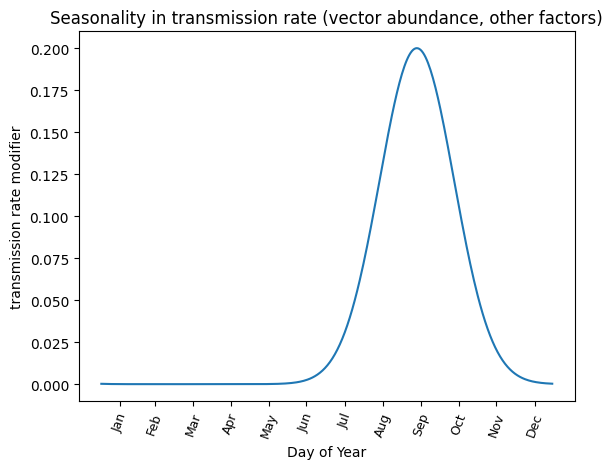

In [5]:
def gaussian(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def seasonality(day_of_year, bump_center, bump_width, bump_height):
    return bump_height * gaussian(day_of_year % 365, bump_center, bump_width)  + bump_height * gaussian(day_of_year % 365 - 365, bump_center, bump_width)  + bump_height * gaussian(day_of_year % 365 + 365, bump_center, bump_width)

# Generate an array of day_of_year values from 1 to 365
days = np.arange(1, 365)

# Calculate the corresponding temperature approximations
seas = [seasonality(day,255,30,0.2) for day in days]


tick_positions = [16, 44, 75, 105, 136, 166, 197, 228, 258, 289, 319, 350]
tick_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Plot the temperature approximations over the year
plt.plot(days, seas)
plt.xlabel('Day of Year')
plt.ylabel('transmission rate modifier')
plt.title('Seasonality in transmission rate (vector abundance, other factors)')
plt.xticks(tick_positions, tick_labels, rotation = 70, fontsize = 9)
plt.show()

Generating the differential equations

In [6]:
def SEIRD_model(y, t, model_parameters: tuple[dict]):

    parameters = model_parameters[0]
    vecpeak: float = parameters['vecpeak']
    vecwidth: float = parameters['vecwidth']
    vecboost: float = parameters['vecboost'] 
    beta: float = parameters['beta'] + seasonality(t, vecpeak, vecwidth, vecboost)
    sigma: float = parameters['sigma'] # transition from Exposed to Infected
    gamma: float = parameters['gamma'] # transition from Infected to Recovered / Dead
    p: float = parameters['p']
    mu: float = parameters['mu']
    N = parameters['N']
    n: int = parameters['n']

    S = defaultdict(float)
    E = defaultdict(float)
    I = defaultdict(float)
    R = defaultdict(float)
    D = defaultdict(float)

    vars = tuple(sum([[S[i], E[i], I[i], R[i], D[i]] for i in range(n)], []))
    vars = y

   # Choosing the corresponding output for each subpopulation
    def entryS(i):
        return vars[5 * i]

    def entryE(i):
        return vars[5 * i + 1]

    def entryI(i):
        return vars[5 * i + 2]

    def entryR(i):
        return vars[5 * i + 3]

    def entryD(i):
        return vars[5 * i + 4]

    # Initializando the directory for each subpopulation
    dS = {}
    dE = {}
    dI = {}
    dR = {}
    dD = {}

    # Defining the differential equations for each subpopulation
    for i in range(n):
        dS[i] = - entryS(i) / (N[i]*1.0) * sum(TransmissionRateMatrix(beta, p)[i][j] * entryI(j) for j in range(n))
        dE[i] = entryS(i) / (N[i]*1.0) * sum(TransmissionRateMatrix(beta, p)[i][j] * entryI(j) for j in range(n)) - sigma * entryE(i)
        dI[i] = sigma * entryE(i) - gamma * entryI(i)
        dR[i] = gamma * (1 - mu) * entryI(i)
        dD[i] = gamma * mu * entryI(i) 
    derivates = sum([[dS[i], dE[i], dI[i], dR[i], dD[i]] for i in range(n)], [])
    return derivates   # For odeint


def generate_sol(genInput: dict) -> dict:
    init = genInput['init']
    n = genInput['n']

    # Initial conditions vector for the metapopulation model. len(initConditions) = 4*n
    initConditions = tuple(sum(
        [[init['S'][i], init['E'][i], init['I'][i], init['R'][i], init['D'][i]] for i in range(n)], []))

    # Time vector
    T = genInput['T']
    t = np.linspace(0, T, T+1)

    # Computing the numerical solution
    model = genInput['model']
    solution = scipy.odeint(model, initConditions, t, args=((genInput,),))

    indexVar = {}
    indexVar['S'] = 0
    indexVar['E'] = 1
    indexVar['I'] = 2
    indexVar['R'] = 3
    indexVar['D'] = 4

    def varSol(patch, var):
        return solution[:, 5*patch + indexVar[var]]

    return {'S': {patch: varSol(patch, 'S') for patch in range(n)},
            'E': {patch: varSol(patch, 'E') for patch in range(n)},
            'I': {patch: varSol(patch, 'I') for patch in range(n)},
            'R': {patch: varSol(patch, 'R') for patch in range(n)},
            'D': {patch: varSol(patch, 'D') for patch in range(n)},
            'N': genInput['N'],
            'init': init,
            'beta': genInput['beta'],
            'p': genInput['p'],
            'gamma': genInput['gamma'],
            'mu':  genInput['mu'],
            'sigma': genInput['sigma'],
            't': t,
            'n': n,
            'vecpeak': genInput['vecpeak'],
            'vecwidth': genInput['vecwidth'],
            'vecboost': genInput['vecboost'],
            'model': model,
            'raw_solution': solution}


In [9]:

# Define the objective function to minimize (sum of squared errors)
def objectiveFunction(parameters, beginTime, endTime, deathData ):
    beta, p, vecpeak, vecwidth, vecboost = parameters
    model_info = {'model': SEIRD_model,
                  'init': {
                      'S': S0,
                      'E': E0,
                      'I': I0,
                      'R': R0,
                      'D': D0,
                  },  # defining the initial values for the model
                  'beta': beta,
                  'p': p,
                  'gamma': 0.06,
                  'sigma': 0.02,
                  'mu': 0.2,
                  'vecpeak': vecpeak,
                  'vecwidth': vecwidth,
                  'vecboost': vecboost,
                  'N': N, 
                  'n': 19,
                  'T': 700} 

    model_sol = generate_sol(model_info)
    totalError = 0
    n = model_info['n']
    for i in range(n):
        initial_position = beginTime[i]
        final_position = endTime[i]
        if (deathData[i] != 0 and final_position != 0):
            try:
                val1 = model_sol['D'][i]
                val2 = val1[final_position]
                val3 = deathData[i]
                totalError += 0.25*(model_sol['D'][i][initial_position] - 1.0)**2 + 0.75*(model_sol['D'][i][final_position] - deathData[i])**2
            except:
                print(n)
                print(i)
                print(final_position)
                print(len(model_sol['D']))
                print(model_sol['D'][i])
                print(deathData[i])
        else:
            totalError += (model_sol['D'][i][initial_position] - 1.0)**2
    return totalError


In [10]:
# Set up the data to fit
beginTime = BeginPlagueByParish
endTime = EndPlagueByParish
deathData = TotalDeathsByParish

# Choose initial guesses for the parameters to fit
beta_guess = 0.3
p_guess = 0.1
vecboost_guess = 0.1
vecpeak_guess = 180.0
vecwidth_guess = 30.0

In [11]:

# Minimize the objective function to obtain estimates for beta and gamma
result = optimize.minimize(objectiveFunction, x0 =(beta_guess, p_guess, vecboost_guess, vecpeak_guess, vecwidth_guess), args=(beginTime, endTime, deathData),
    method='L-BFGS-B'
    #, bounds=[(0,1),(0,1),(0, 10), (-2, 2), (-10, 10)]
    )
beta_estimated, p_estimated, vecboost_estimated, vecpeak_estimated, vecwidth_estimated= result.x

print("beta = ", beta_estimated)
print("p = ", p_estimated)
print("vecboost = ", vecboost_estimated)
print("vecpeak = ", vecpeak_estimated)
print("vecwidth = ", vecwidth_estimated)

/usr/local/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


beta =  0.22685072621740734
p =  -0.001229210838037273
vecboost =  0.01757187268933138
vecpeak =  179.91331869072366
vecwidth =  29.91289606418357


In [10]:
#option for objective function
#(sum(model_sol['I'][i][position] for position in range(initial_position, final_position))-0.6*deathData[i])**2

# Set up the data to fit
beginTime = BeginPlagueByParish
endTime = EndPlagueByParish
deathData = TotalDeathsByParish

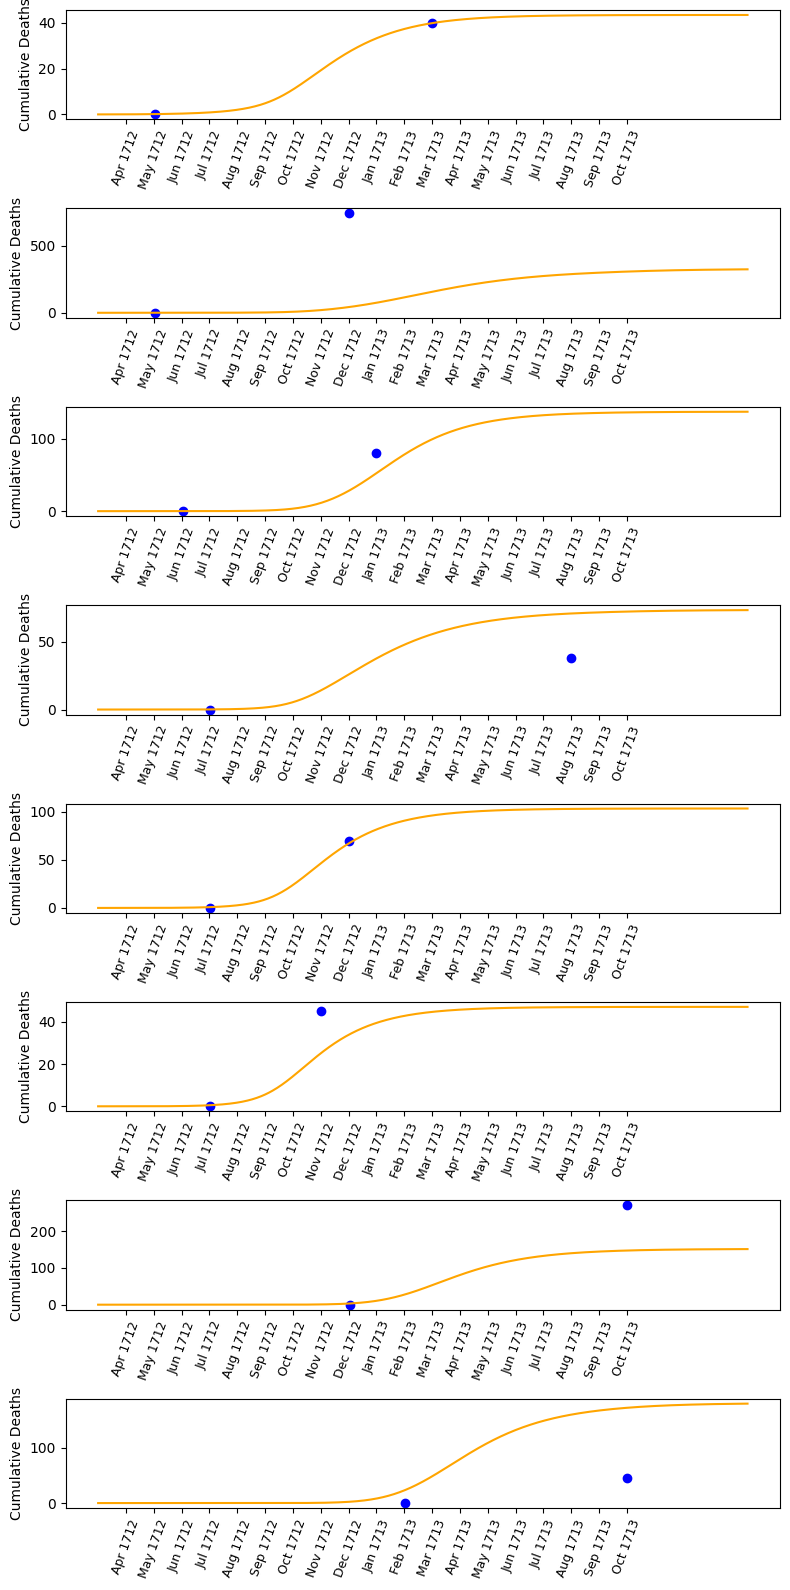

In [11]:
# Manually fit the model
model_estimation = {'model': SEIRD_model,
                  'init': {
                      'S': S0,
                      'E': E0,                      
                      'I': I0,
                      'R': R0,
                      'D': D0,
                  },  # defining the initial values for the model
                  'beta': 0.1,
                  'vecboost': 0.1,
                  'p': 0.05, #0.000000004,
                  'vecpeak': 180,
                  'vecwidth': 30,
                  'sigma': 0.02,
                  'gamma': 0.06,
                  'mu': 0.2,
                  'N': N,
                  'n': 19,
                  'T': 700}

model_dict = generate_sol(model_estimation)

# Number of patches
n = 8 # model_estimation['n']

# Set the figsize for each subplot
figsize_single_subplot = (8, 2)

# Calculate the total figure height based on the number of subplots and their height
fig_height = figsize_single_subplot[1] * n

# Create a figure and an array of axes with nrows=n and ncols=1
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(
     figsize_single_subplot[0], fig_height),sharex=False)

tick_positions = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570]
tick_labels = ["Apr 1712", "May 1712", "Jun 1712", "Jul 1712", "Aug 1712", "Sep 1712", "Oct 1712"
               , "Nov 1712", "Dec 1712", "Jan 1713", "Feb 1713", "Mar 1713", "Apr 1713"
               , "May 1713", "Jun 1713", "Jul 1713", "Aug 1713", "Sep 1713", "Oct 1713"
              ]

# Dictionary that reduces the plotting to those plots with data
lookup_index = [1,2,4,8,9,12,16,17]

# Plot daily deaths for each patch i
for i in range(n):
    if TotalDeathsByParish[lookup_index[i]] != 0 and EndPlagueByParish[lookup_index[i]] != 0:
        initial_position = beginTime[lookup_index[i]]
        final_position = EndPlagueByParish[lookup_index[i]]
        axes[i].plot(initial_position,0, 'bo')
        axes[i].plot(final_position,TotalDeathsByParish[lookup_index[i]], 'bo')
        axes[i].plot(model_dict['D'][lookup_index[i]], color='orange')
        #axes[i].plot(model_dict['D'][lookup_index[i]], color='orange', label=(patchNames[lookup_index[i]]))
        axes[i].set_ylabel('Cumulative Deaths')
        #axes[i].legend(loc = 'lower right')
        axes[i].set_xticks(tick_positions, tick_labels, rotation = 70, fontsize = 9)
    else:
        axes[i].plot(model_dict['D'][lookup_index[i]], color='orange', label=(patchNames[lookup_index[i]]))
        axes[i].set_ylabel('Cumulative Deaths')
        axes[i].legend(loc = 'lower right')
        axes[i].set_xticks(tick_positions, tick_labels, rotation = 70, fontsize = 9)
           
# Adjust the layout to avoid overlapping
plt.tight_layout()
plt.show()

In [ ]:
model_estimation = {'model': SIRD_model,
                  'init': {
                      'S': S0,
                      'I': I0,
                      'R': R0,
                      'D': D0,
                  },  # defining the initial values for the model
                  'beta': beta_estimated,
                  'p': p_estimated,
                  'beta0': beta0_estimated,
                  'beta1': beta1_estimated,
                  'a': a_estimated,
                  'gamma': 0.32,
                  'mu': 0.6,
                  'N': N,
                  'n': 19,
                  'T': 700}
model_dict = generate_sol(model_estimation)


Plotting the solutions

In [10]:
#Computing the daily deaths from the model output for a given patch
def daily_deaths(solution_model: dict, patch: int, T_inf: int, T_sup: int) -> list[float]:
    assert T_inf >= 0, "t must be greater than 0"
    assert T_sup >= 0, "t must be greater than 0"
    cumulative_deaths = solution_model['D'][patch] # list of floats         
    return [cumulative_deaths[t+1] - cumulative_deaths[t]
                for t in range(T_inf, T_sup)]

# Plotting the solution
def plot_SIRD_solution(model: dict, state: list[str] = ['S', 'I', 'R', 'D', 'DailyDeaths']):

    for key in state:
        if key not in model:
            raise ValueError(f"Invalid state: {key}")
        for i in range(model['n']):
            plt.plot(model['t'], model[key][i], label=f'{key} - {patchNames[i]}')
    plt.xlabel('Time')
    plt.ylabel('Infectious')
    plt.title('SIRD model')
    #plt.legend(loc="upper center", mode ="expand",  ncol = 19, bbox_to_anchor=(0.5, -0.25))
    plt.show()


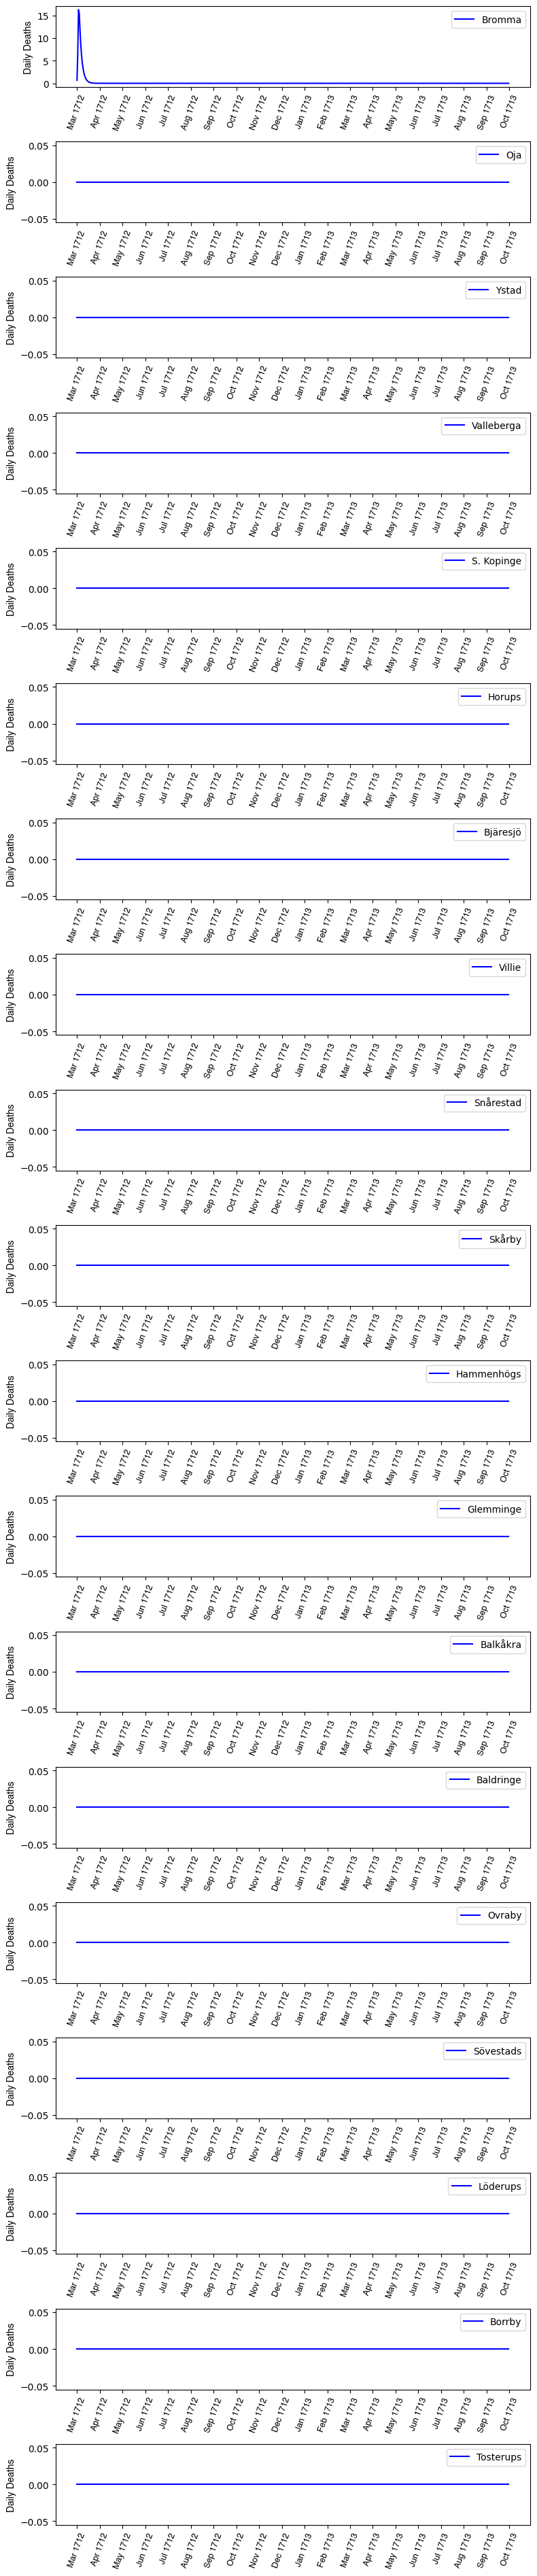

In [ ]:
# Set the figsize for each subplot
figsize_single_subplot = (8, 2)

# Calculate the total figure height based on the number of subplots and their height
fig_height = figsize_single_subplot[1] * n

# Create a figure and an array of axes with nrows=n and ncols=1
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(
    figsize_single_subplot[0], fig_height))

tick_labels = ["Mar 1712", "Apr 1712", "May 1712", "Jun 1712", "Jul 1712", "Aug 1712", "Sep 1712"
              , "Oct 1712", "Nov 1712", "Dec 1712", "Jan 1713", "Feb 1713", "Mar 1713", "Apr 1713"
              , "May 1713", "Jun 1713", "Jul 1713", "Aug 1713", "Sep 1713", "Oct 1713"
              ]
tick_positions = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570]


for i in range(n):
    # Plot daily deaths for each patch i
    axes[i].plot(daily_deaths(model_dict, i, 0, 570),
                 color='blue', label=(patchNames[i]))
    axes[i].set_ylabel('Daily Deaths', font='Helvetica')
    axes[i].legend(loc='upper right')
    axes[i].xaxis.set_ticks(tick_positions, tick_labels, rotation=70, font = 'Helvetica', fontsize=9)

# Adjust the layout to avoid overlapping
plt.tight_layout()
plt.show()
